In [14]:
#Project Title : Predicting Stock Market using Traditional and Alternative Data

# The Goal of this Project is to identify the drivers of the stock exchange values of different companies, and build 
# a predictor to predict stock prices over a long term.

# I want to build a predictor that takes into account the 
    #1. Hiring, and popularity of companies using Linkedin data provided by Thinknum
    #2. Past values of stocks 
    #3. Public Sentiment of CEOs using tweets scraped from Twitter
    #4. Employee sentiment using reviews scraped from Glassdoor - This can help us in understanding the health of a 
    #   particular company beforehand. - Pending for the Final Capstone Project
    #5. Weather Data provided by NOAA - Pending for the Final Capstone Project
    #6. More Sentiment Analysis of the geopolitical news around the country
    
    #7. Traditional stock market predictors like oil prices, international stock market prices - Pending for the Final Capstone Project

#WorkFlow in This NOTEBOOK : 
# 1. Get the Linkedin data from ThinkNum between 2015 and 2018
# 2. Get the S&P 500 Stocks data from https://www.kaggle.com/camnugent/sandp500
# 3. Scrape Google to get the complete company names for the symbols in the Stocks Data as Linkedin Data has full company names
# 4. Using full company names, find the companies that are common between the above two datasets.
# 4. Scrape Google to get the the CEO's of each of these companies and their Twitter handle.
# 5. Using Twitter API, download all the tweets of the CEOs.
# 5. Perform a sentiment analysis of all the tweets between 2015 and 2018 and create a timeline.
# 6. Analyze the stocks, company growth and sentiments of the CEOs.

# More Thoughts :
# 1. I am also interested in understanding the correlation between different industries and how they drive each 
# other's stock prices.

# 2. This will help us in understanding which companies' stocks depend more on alternative data, for example, a popular
# CEO will have larger influencing in driving the stock prices.
    
# 2. The analysis will span a time period of 3 years, 2015-2018 for companies across different industries 
# 
# 3. While working on this project, I will be looking for more datasets that can help in improving this predictor.

In [15]:
import pandas as pd
import numpy as np
import ipdb
import matplotlib.pyplot as plt
import re
from bokeh.plotting import figure, show, output_file, output_notebook
from bokeh.palettes import Spectral11, colorblind, Inferno, BuGn, brewer
from bokeh.models import HoverTool, value, LabelSet, Legend, ColumnDataSource,\
LinearColorMapper,BasicTicker, PrintfTickFormatter, ColorBar, Dropdown, Select, CustomJS,RadioGroup 
from bokeh.io import curdoc
from bokeh.layouts import column, gridplot, row
import datetime as dt
from bs4 import BeautifulSoup
from selenium import webdriver 
import time
import os
import requests
from textblob import TextBlob
from wordcloud import WordCloud
from collections import OrderedDict
import csv

In [3]:
!pip install pyquery

In [14]:
import bokeh
bokeh.__version__

'2.1.1'

In [16]:
#Loading the ThinkNum Data
df_linkedin=pd.read_csv('temp_datalab_records_linkedin_company.csv')
relevant_columns=['as_of_date','company_name','followers_count','employees_on_platform','industry']


/Users/garima/pydarn/venv_pydarn/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [20]:
df_lnkd=df_linkedin[relevant_columns]
df_lnkd['as_of_date']=pd.to_datetime(df_lnkd['as_of_date'])

/Users/garima/pydarn/venv_pydarn/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Exploring the Linkedin Dataset

In [21]:
df_lnkd.shape

(2426196, 5)

In [22]:
df_lnkd.head()

,as_of_date,company_name,followers_count,employees_on_platform,industry
0,2015-09-14,Goldman Sachs,552254,38124,Investment Banking
1,2015-09-15,Goldman Sachs,552862,38141,Investment Banking
2,2015-09-16,United Technologies,59157,14982,Aviation & Aerospace
3,2015-09-16,Novo Nordisk,336175,26448,Pharmaceuticals
4,2015-09-16,"Lowe's Companies, Inc.",134255,62574,Retail


In [23]:
df_lnkd.describe()

,followers_count,employees_on_platform
count,2.426196e+06,2.426196e+06
mean,7.167738e+04,7.587255e+03
std,2.638344e+05,2.412444e+04
min,0.000000e+00,0.000000e+00
25%,2.148000e+03,2.180000e+02
50%,9.335000e+03,1.083000e+03
75%,3.864200e+04,4.513000e+03
max,7.833967e+06,5.779520e+05


In [24]:
#Number of unique company names
df_lnkd.company_name.unique().shape

(5028,)

In [25]:
#Number of unique industry names
industry=df_lnkd.industry.unique().shape
industry

(141,)

In [26]:
min(df_lnkd['as_of_date'])

Timestamp('2015-09-14 00:00:00')

In [27]:
max(df_lnkd['as_of_date'])

Timestamp('2018-07-17 00:00:00')

In [28]:
#Industries with the Largest Followers
grouped=df_lnkd.groupby('industry').sum().reset_index()
grouped.sort_values('followers_count', ascending=False).head(10)

,industry,followers_count,employees_on_platform
62,Information Technology and Services,19775577695,2383349091
65,Internet,15889193478,540464477
40,Financial Services,10208046449,1701931846
93,Oil & Energy,10078940736,609859377
21,Computer Software,9387919641,490204437
101,Pharmaceuticals,7323159940,645660609
119,Retail,6762282982,1424502315
24,Consumer Goods,6496724677,404053850
4,Automotive,4992425224,531717088
7,Banking,4341912352,961924799


In [29]:
grouped.sort_values('followers_count')

,industry,followers_count,employees_on_platform
85,Military,0,0
92,Nonprofit Organization Management,7253,1863
51,Graphic Design,7837,4184
107,Program Development,12575,1335
79,Market Research,38070,2987
...,...,...,...
21,Computer Software,9387919641,490204437
93,Oil & Energy,10078940736,609859377
40,Financial Services,10208046449,1701931846
65,Internet,15889193478,540464477


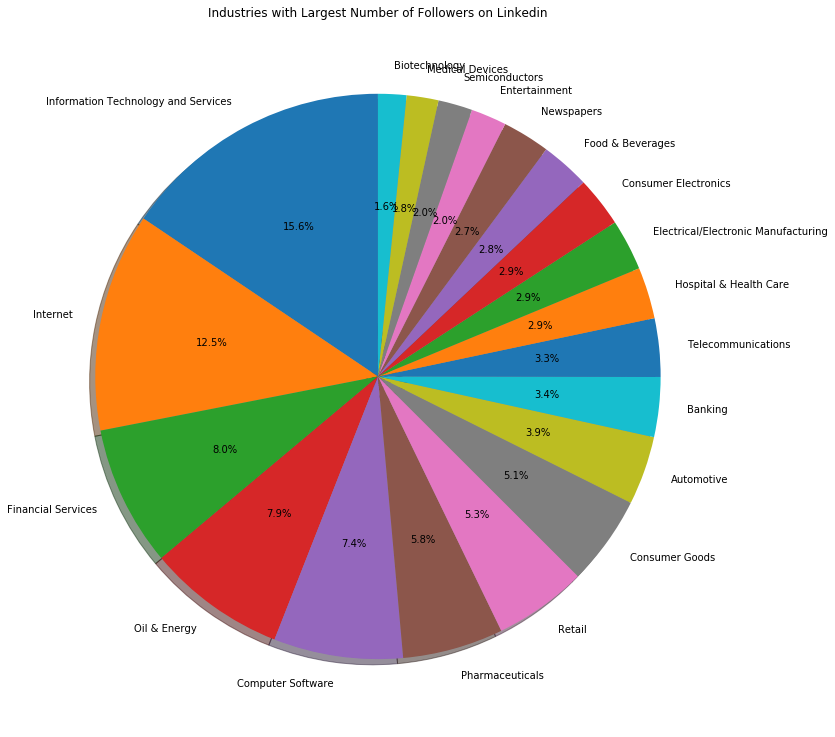

In [15]:
labels = grouped.sort_values('followers_count', ascending=False)['industry'].values[:20]
sizes = grouped.sort_values('followers_count', ascending=False)['followers_count'].values[:20]
fig=plt.figure(figsize=(13,13))
ax1 = fig.add_subplot(111)
ax1.pie(sizes,labels=labels,autopct='%1.1f%%',shadow=True, startangle=90)
ax1.set_title('Industries with Largest Number of Followers on Linkedin')
plt.show()

In [30]:
#Industries with the Largest Employees on Linkedin
grouped.sort_values('employees_on_platform', ascending=False).head(10)

,industry,followers_count,employees_on_platform
62,Information Technology and Services,19775577695,2383349091
40,Financial Services,10208046449,1701931846
119,Retail,6762282982,1424502315
7,Banking,4341912352,961924799
127,Telecommunications,4243041664,925623563
101,Pharmaceuticals,7323159940,645660609
93,Oil & Energy,10078940736,609859377
65,Internet,15889193478,540464477
4,Automotive,4992425224,531717088
21,Computer Software,9387919641,490204437


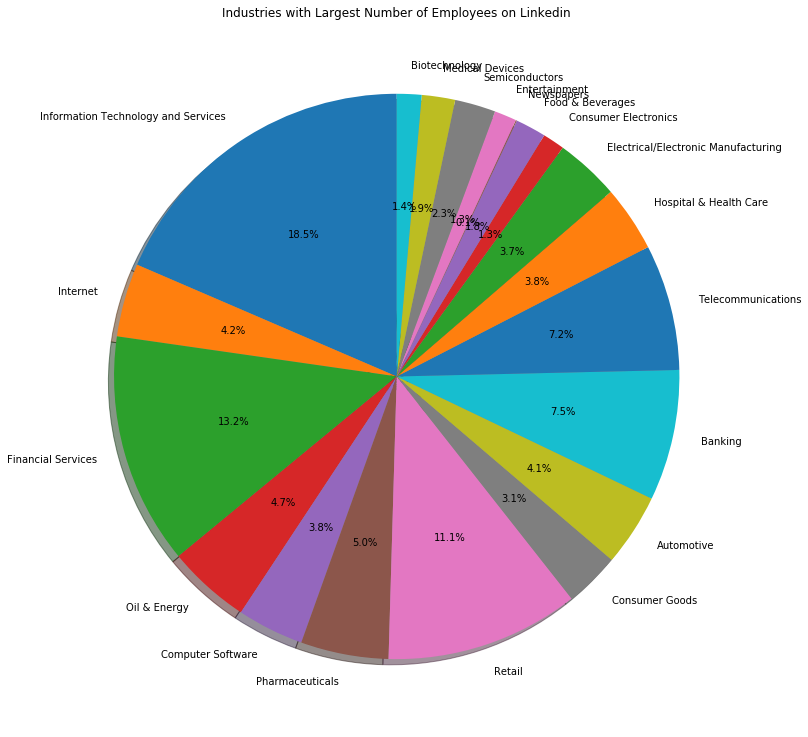

In [17]:
labels = grouped.sort_values('followers_count', ascending=False)['industry'].values[:20]
sizes = grouped.sort_values('followers_count', ascending=False)['employees_on_platform'].values[:20]
fig=plt.figure(figsize=(13,13))
ax1 = fig.add_subplot(111)
ax1.pie(sizes,labels=labels,autopct='%1.1f%%',shadow=True, startangle=90)
ax1.set_title('Industries with Largest Number of Employees on Linkedin')
plt.show()

Information Technology and Services has the largest followers and employees on Linkedin

In [31]:
#We select certain industries that have large amount of companies and less noisy data by visual inspection of the above plots
#select_ind=['Pharmaceuticals','Retail','Hospital & Health Care','Banking','Information Technology and Services',\
#           'Internet','Semiconductors','Oil & Energy','Automotive','Consumer Goods','Mining & Metals','Chemicals','Financial Services',\
#           'Computer Software','Defense & Space','Airlines/Aviation']

#For the purpose of this exploratory analysis, I will select only one industry
# In my final capstone project, I intend to use all the above industries for my analysis
plt.style.use('ggplot')

select_ind=['Information Technology and Services']

#Plotting only the Largest companies in terms of employees

df_large_ind=pd.DataFrame()

for ind in select_ind:
    sel_ind=df_lnkd[df_lnkd.industry==ind]
    #unq_comp=sel_ind.company_name.unique()
    
    grouped_comp=sel_ind.groupby('company_name').sum()['employees_on_platform'].nlargest(10)
    largest_companies=grouped_comp.keys()
    
    for icomp in largest_companies:
        sel_comp=sel_ind[sel_ind.company_name==icomp]
        sel_comp=sel_comp.sort_values(by='as_of_date')
        #normalize data for each company as we wish to see the growth rather than absolute numbers
        sel_comp['followers_count']=sel_comp['followers_count']-sel_comp['followers_count'].mean()
        sel_comp['employees_on_platform']=sel_comp['employees_on_platform']-sel_comp['employees_on_platform'].mean()
        df_large_ind=df_large_ind.append(sel_comp)

In [32]:
df_large_ind.shape

(8144, 5)

/usr/local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


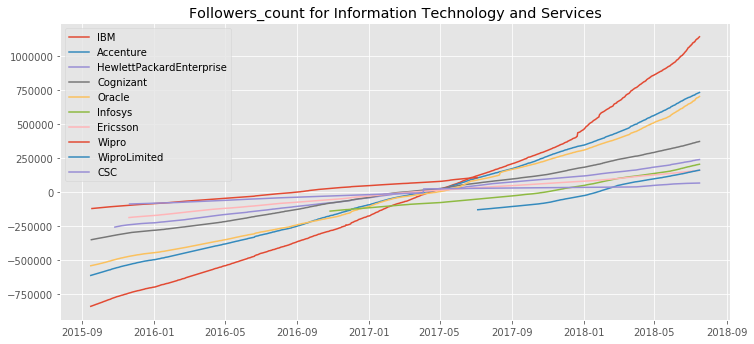

In [20]:
#Plotting the Time series for largest companies in the selected Industry
fig=plt.figure(figsize=(12,12))
for i,ind in enumerate(select_ind):
    ax=fig.add_subplot(2,1,i+1)
    sel_ind=df_large_ind[df_large_ind.industry==ind]

    comps=sel_ind['company_name'].unique()
    for icomp in comps:
        sel_comp=sel_ind[sel_ind.company_name==icomp]
        label=re.sub('\W+','', icomp )
        ax.plot(sel_comp['as_of_date'],sel_comp['followers_count'],label=label)
        ax.legend(loc='best')
    ax.set_title('Followers_count for '+ind)



The number of Followers for IT services have been steadily increasing on Linkedin. This might tell us more
about the popularity of Linkedin itself rather than the companies's growth.

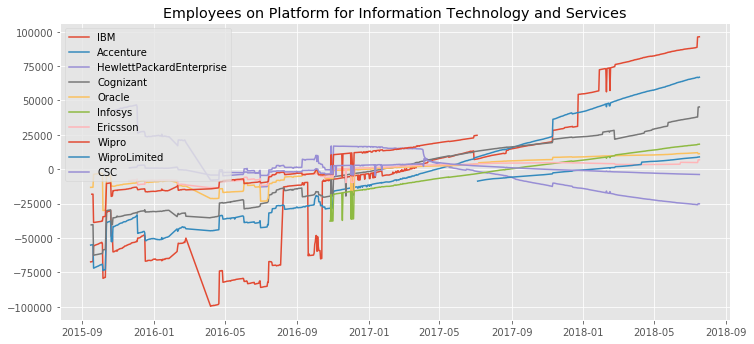

In [21]:
fig=plt.figure(figsize=(12,12))
for i,ind in enumerate(select_ind):
    ax=fig.add_subplot(2,1,i+1)
    sel_ind=df_large_ind[df_large_ind.industry==ind]
    comps=sel_ind['company_name'].unique()

    for icomp in comps:
        sel_comp=sel_ind[sel_ind.company_name==icomp]
        label=re.sub('\W+','', icomp )
        ax.plot(sel_comp['as_of_date'],sel_comp['employees_on_platform'],label=label)
        ax.legend()
    ax.set_title('Employees on Platform for '+ind)
    


The number of employees for some companies in the IT sector however do not show a clean linear growth. In fact, for some of the companies the employees have decreased over the years.

# Exploring the Stocks Dataset

In [33]:
#Loading the Stocks Data from https://www.kaggle.com/camnugent/sandp500
df_stocks=pd.read_csv('all_stocks_5yr.csv')

In [34]:
df_stocks.describe()

,open,high,low,close,volume
count,619029.000000,619032.000000,619032.000000,619040.000000,6.190400e+05
mean,83.023334,83.778311,82.256096,83.043763,4.321823e+06
std,97.378769,98.207519,96.507421,97.389748,8.693610e+06
min,1.620000,1.690000,1.500000,1.590000,0.000000e+00
25%,40.220000,40.620000,39.830000,40.245000,1.070320e+06
50%,62.590000,63.150000,62.020000,62.620000,2.082094e+06
75%,94.370000,95.180000,93.540000,94.410000,4.284509e+06
max,2044.000000,2067.990000,2035.110000,2049.000000,6.182376e+08


In [35]:
df_stocks.head(5)

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [36]:
df_stocks['date']=pd.to_datetime(df_stocks['date'])

In [37]:
#Selecting the times for when Linkedin Data exists
df_stocks_cut=df_stocks[(df_stocks['date']>=dt.datetime(2015,9,14)) & (df_stocks['date']<dt.datetime(2018,7,18))]
df_stocks_cut.head(5)

,date,open,high,low,close,volume,Name
653,2015-09-14,42.17,42.5000,41.8400,42.29,7362535,AAL
654,2015-09-15,42.36,42.8500,41.8900,42.64,7009325,AAL
655,2015-09-16,42.40,43.2467,42.2400,43.06,7703119,AAL
656,2015-09-17,43.11,44.5900,42.9899,43.99,12835651,AAL
657,2015-09-18,43.43,44.0300,43.2750,43.49,12446861,AAL


/Users/garima/pydarn/venv_pydarn/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


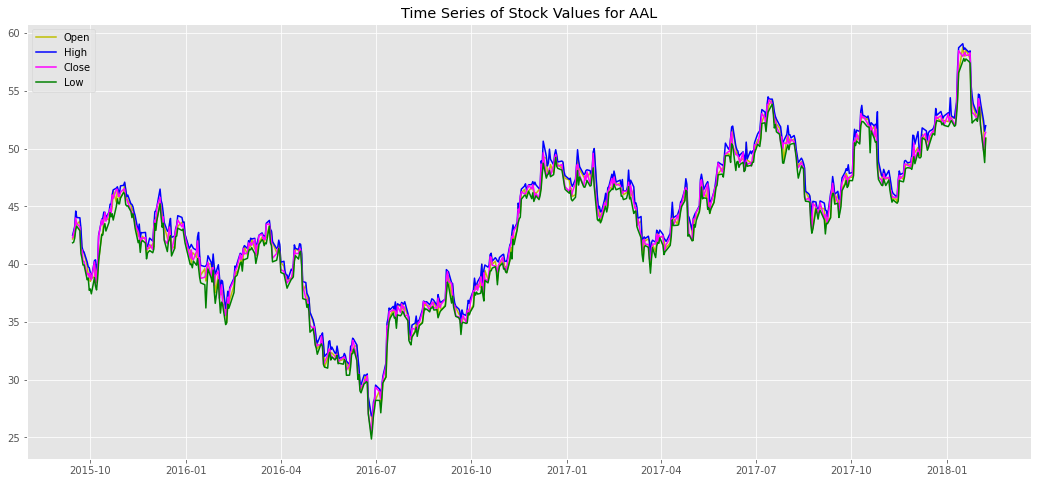

In [38]:
fig=plt.figure(figsize=(18,8))
ax=fig.add_subplot(111)
unq_sym=df_stocks['Name'].unique()
#Looking at Time series for
for sym in unq_sym[:1]:
    df_sel=df_stocks_cut[df_stocks_cut['Name']==sym]
    df_sel=df_sel.sort_values(by='date')
    ax.plot(df_sel['date'],df_sel['open'],label='Open',c='y')
    ax.plot(df_sel['date'],df_sel['high'],label='High',c='b')
    ax.plot(df_sel['date'],df_sel['close'],label='Close',c='magenta')
    ax.plot(df_sel['date'],df_sel['low'],label='Low',c='g')
    ax.legend(loc='best')
    ax.set_title('Time Series of Stock Values for '+sym)

Since all of these columns are correlated with each other, we will choose one of them for further analysis

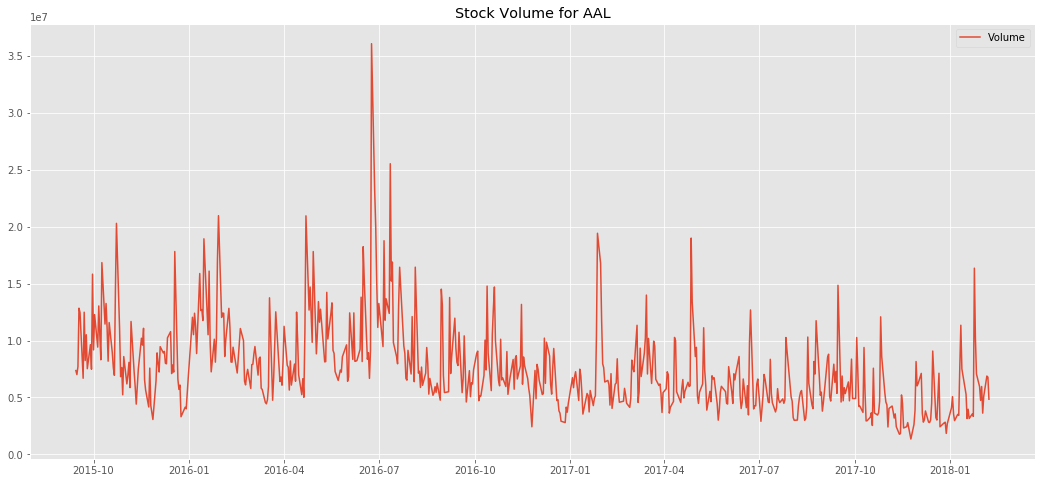

In [28]:
fig=plt.figure(figsize=(18,8))
ax=fig.add_subplot(111)
unq_sym=df_stocks['Name'].unique()
#Looking at Time series for
for sym in unq_sym[:1]:
    df_sel=df_stocks_cut[df_stocks_cut['Name']==sym]
    df_sel=df_sel.sort_values(by='date')
    ax.plot(df_sel['date'],df_sel['volume'],label='Volume')
    ax.legend(loc='best')
    ax.set_title('Stock Volume for '+sym)
    
#Unlike stock values, the Volume data does not have a trend over the years.

# Scraping the Full Names of the Companies from the symbols in the Stocks Dataset

In [39]:
# Finding the Unique stock Names
df_stocks_cut['Name'].unique()

array(['AAL', 'AAPL', 'AAP', 'ABBV', 'ABC', 'ABT', 'ACN', 'ADBE', 'ADI',
       'ADM', 'ADP', 'ADSK', 'ADS', 'AEE', 'AEP', 'AES', 'AET', 'AFL',
       'AGN', 'AIG', 'AIV', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALGN', 'ALK',
       'ALLE', 'ALL', 'ALXN', 'AMAT', 'AMD', 'AME', 'AMGN', 'AMG', 'AMP',
       'AMT', 'AMZN', 'ANDV', 'ANSS', 'ANTM', 'AON', 'AOS', 'APA', 'APC',
       'APD', 'APH', 'APTV', 'ARE', 'ARNC', 'ATVI', 'AVB', 'AVGO', 'AVY',
       'AWK', 'AXP', 'AYI', 'AZO', 'A', 'BAC', 'BAX', 'BA', 'BBT', 'BBY',
       'BDX', 'BEN', 'BF.B', 'BHF', 'BHGE', 'BIIB', 'BK', 'BLK', 'BLL',
       'BMY', 'BRK.B', 'BSX', 'BWA', 'BXP', 'CAG', 'CAH', 'CAT', 'CA',
       'CBG', 'CBOE', 'CBS', 'CB', 'CCI', 'CCL', 'CDNS', 'CELG', 'CERN',
       'CFG', 'CF', 'CHD', 'CHK', 'CHRW', 'CHTR', 'CINF', 'CI', 'CLX',
       'CL', 'CMA', 'CMCSA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP',
       'COF', 'COG', 'COL', 'COO', 'COP', 'COST', 'COTY', 'CPB', 'CRM',
       'CSCO', 'CSRA', 'CSX', 'CTAS', 'CTL', 'CTSH', 'CTXS

In [ ]:
#scrape stock symbols
#Please comment this if don't need to scrape again and simply load the file from the 
# next cell
#This cell takes some time to run , ~around an hour
'''
def scrape_stocks(stock_ticks):
    options = webdriver.ChromeOptions()
    options.add_argument('--ignore-ssl-errors=yes')
    options.add_argument('--ignore-certificate-errors')
    browser = webdriver.Chrome(options=options)
    #browser.implicitly_wait(10)
    stock_dic={}
    for tickr in stock_ticks:
        time.sleep(5)
        search_string = tickr+' stock symbol'
        print(search_string)
        for i in range(1):
            search_str="https://www.google.com/search?q=" + search_string + "&start=" + str(i)
            browser.get(search_str) 
            html_source = browser.page_source
            soup = BeautifulSoup(html_source)
            spans=soup.find_all('span',attrs={'class':'vk_bk'})
            try : 
                span=spans[0]
                stock_dic[tickr]=span.text
            except IndexError:
                pass

    browser.quit()
    df=pd.DataFrame([stock_dic]).T
    df.to_csv('stock_symbols_file.csv')

stock_ticks=df_stocks_cut['Name'].unique()    
scrape_stocks(stock_ticks)

#Some stocks symbols gave wrong google results, so I manually corrected these- HP, APC, UA
'''

In [40]:
# Directly Reload this file if scraping has been done already
df_stocks_names=pd.read_csv('stock_symbols_file2.csv')

In [41]:
df_stocks_names.head() #This is the dataframe generated by the above scraping routine

,Unnamed: 0,0
0,AAL,American Airlines Group Inc
1,AAPL,Apple Inc.
2,AAP,"Advance Auto Parts, Inc."
3,ABBV,AbbVie Inc
4,ABC,AmerisourceBergen Corp.


In [42]:
def format_comp_name(comp_name):
    comp_name=comp_name.lower()
    comp_name=re.sub('inc','', comp_name)
    comp_name=re.sub('corporation','', comp_name)
    comp_name=re.sub('corp','', comp_name)
    comp_name=re.sub('\W+','', comp_name)
    comp_name=re.sub('group','',comp_name)
    return comp_name

In [43]:
df_stocks_names['company_name_format']=df_stocks_names[u'0'].apply(format_comp_name)

In [44]:
df_stocks_names.head(2)

,Unnamed: 0,0,company_name_format
0,AAL,American Airlines Group Inc,americanairlines
1,AAPL,Apple Inc.,apple


# Linking the full company names in Linkedin Dataset
# with the stock symbols and finding corresponding companies in the S&P index dataset

In [45]:
#Formatting the names of the companies to remove any discrepancy in the company names between
# the two datasets
df_lnkd['company_name_format']=df_lnkd['company_name'].apply(format_comp_name)

/Users/garima/pydarn/venv_pydarn/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [46]:
df_stocks_cut.head(2)

,date,open,high,low,close,volume,Name
653,2015-09-14,42.17,42.50,41.84,42.29,7362535,AAL
654,2015-09-15,42.36,42.85,41.89,42.64,7009325,AAL


In [47]:
df_lnkd.head(2)

,as_of_date,company_name,followers_count,employees_on_platform,industry,company_name_format
0,2015-09-14,Goldman Sachs,552254,38124,Investment Banking,goldmansachs
1,2015-09-15,Goldman Sachs,552862,38141,Investment Banking,goldmansachs


In [48]:
df_stocks_names.columns

Index(['Unnamed: 0', '0', 'company_name_format'], dtype='object')

In [49]:
#Finding common companies between the stocks dataframe and the linkedin dataframe
#Creating a new dataframe with common companies
df_select=pd.DataFrame()
for i,icomp in enumerate(df_stocks_names['company_name_format'].values):
    row_select=df_lnkd[df_lnkd['company_name_format']==icomp]
    sym=df_stocks_names.iloc[i]['Unnamed: 0']
    #Adding a column of stock symbol to the Linkedin DataFrame
    row_select['Sym']=sym
    df_select=df_select.append(row_select)

/Users/garima/pydarn/venv_pydarn/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [50]:
df_select.shape

(247262, 7)

In [51]:
df_select.head()

,as_of_date,company_name,followers_count,employees_on_platform,industry,company_name_format,Sym
164,2015-09-17,American Airlines,182897,35311,Airlines/Aviation,americanairlines,AAL
415,2015-09-18,American Airlines,183147,35324,Airlines/Aviation,americanairlines,AAL
795,2015-09-19,American Airlines,183277,35336,Airlines/Aviation,americanairlines,AAL
1216,2015-09-20,American Airlines,183420,35342,Airlines/Aviation,americanairlines,AAL
1688,2015-09-21,American Airlines,183576,29360,Airlines/Aviation,americanairlines,AAL


In [52]:
common_companies=df_select.company_name.unique()
common_companies.shape

(304,)

In [115]:
df_select.to_csv('df_common.csv')

These are the common companies between the Linkedin Dataset and the S&P 500 dataset that we will use further

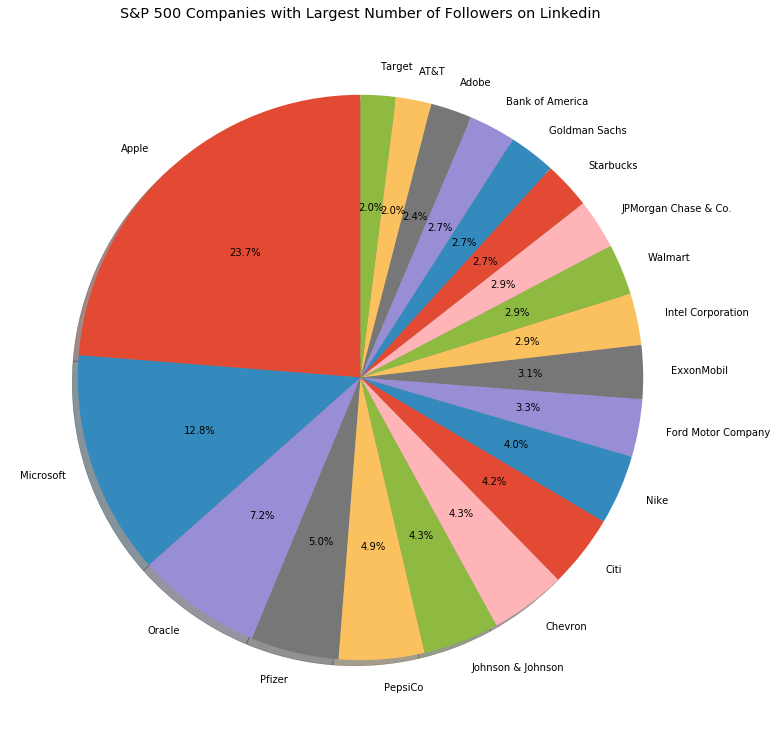

In [116]:
labels = grouped.sort_values('followers_count', ascending=False).index.values[:20]
sizes = grouped.sort_values('followers_count', ascending=False)['followers_count'].values[:20]
fig=plt.figure(figsize=(13,13))
ax1 = fig.add_subplot(111)
ax1.pie(sizes,labels=labels,autopct='%1.1f%%',shadow=True, startangle=90)
ax1.set_title('S&P 500 Companies with Largest Number of Followers on Linkedin')
plt.show()

#Apple, Microsoft, Oracle have the largest number of followers on Linkedin

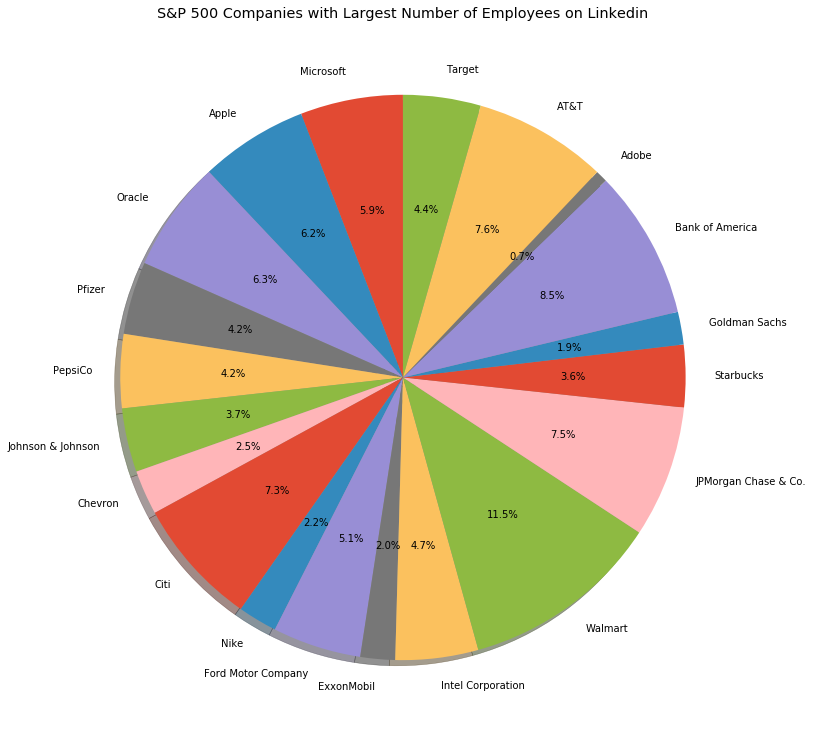

In [117]:
grouped=df_select.groupby('company_name').sum()
labels = grouped.sort_values('followers_count', ascending=False).index.values[:20]
sizes = grouped.sort_values('followers_count', ascending=False)['employees_on_platform'].values[:20]
fig=plt.figure(figsize=(13,13))
ax1 = fig.add_subplot(111)
ax1.pie(sizes,labels=labels,autopct='%1.1f%%',shadow=True, startangle=90)
ax1.set_title('S&P 500 Companies with Largest Number of Employees on Linkedin')
plt.show()

#Apple, Walmart, Bank of America have the largest number of employees on Linkedin

# Scraping the Names of the CEOs of the Common Companies

In [ ]:
'''
#Downloading the names of the CEOs of S&P 500 companies
def download_company_ceo(company_names):
    options = webdriver.ChromeOptions()
    options.add_argument('--ignore-ssl-errors=yes')
    options.add_argument('--ignore-certificate-errors')
    browser = webdriver.Chrome(options=options)
    twitter_ceo={}
    twitter_handle={}
    for scomp in company_names[-6:-4]:
        time.sleep(5)
        search_string = 'CEO of '+ scomp
        print(search_string)
        for i in range(1):
            search_str="https://www.google.com/search?q=" + search_string + "&start=" + str(i)
            browser.get(search_str) 
            html_source = browser.page_source
            soup = BeautifulSoup(html_source)
            spans=soup.find_all('a',attrs={'class':'FLP8od'})
            try :
                span=spans[0]
                ceo_name=span.text
                time.sleep(5)
                search_string = ceo_name+' twitter'
                search_str="https://www.google.com/search?q=" + search_string + "&start=" + str(i)
                browser.get(search_str) 
                html_source = browser.page_source
                soup = BeautifulSoup(html_source)
                ipdb.set_trace()
                #spans=soup.find_all('h3',attrs={'class':'LC20lb DKV0Md'})
                #spans=soup.find_all('a',attrs={'class':'r'})
                spans=soup.find_all('cite',attrs={'class':'ellip D5gSDf bwSSse iUh30'})
                tt=spans[0].text
                twitter_handle=tt[tt.find("(")+1:tt.find(")")]
                twitter_handle=re.sub('@','',twitter_handle)
                twitter_ceo[scomp]=ceo_name
                twitter_handle[scomp]=twitter_handle
            except: 
                pass
    browser.quit()
    df_twitter=pd.DataFrame([twitter_dic]).T
    df_twitter.to_csv('ceo_twitter_handles.csv')
'''

In [53]:
#Get Names of the companies
#df_select=pd.read_csv('df_common.csv')
company_names=df_select['company_name'].unique()
download_company_ceo(company_names)

NameError: name 'download_company_ceo' is not defined

# Scraping the Tweets of the CEOs of the above common companies

In [ ]:
#Download tweets of the CEOs S&P 500 companies that are also present in the Linkedin Dataset

#Some of them don't have twitter accounts, so I have manually deleted some of the wrong downloads
# I use the package available at https://github.com/marquisvictor/Optimized-Modified-GetOldTweets3-OMGOT/blob/master/GetOldTweets3-0.0.10/GetOldTweets3.py

#This takes quite a while so rerun with caution
'''
df_handles=pd.read_csv('ceo_twitter_handles.csv')
vals=df_handles['0'].values
handles=[]
#valid_handle=[]
for val in vals:
    bb=val.split(',')[1]
    hh=re.sub('\W+','',bb)
    handles.append(hh)
    
for hh in handles:
    if not(os.path.exists(hh)):
        os.makedirs(hh)
    os.chdir(hh)
    ! ../GetOldTweets3.py --username $hh --since 2015-01-01 --until 2019-01-01
    os.chdir('../')
'''

# Performing Sentiment Analysis on the Tweets

In [54]:
#Loading the Tweet sentiments for only two people in this notebook
#To understand the influence of political environment on stocks

def clean_tweet(tweet):
    tweet = tweet.lower()
    regs = [
        r'(\/\/www[^\s]+)',
        r'(pic.twitter.com\/[^\s]+)',
        r'(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)',
        r'(?i)\b((?:https?:\/\/[^\s]+))',
        r'https'
    ]
    prev = tweet
    for reg in regs:
        prev = re.sub(reg, " ", prev)
    return prev

def get_tweets_list(account):
    tweets = []
    path='/Users/garima/'
    with open(f'{path}tweet_folders/{account}/output_got.csv') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        keys = next(csv_reader)
        for i,row in enumerate(csv_reader):
            tweet = {}
            tweet[keys[0]] = row[0]
            tweet[keys[1]] = row[1]
            tweet[keys[6]] = clean_tweet(row[6])
            tweets.append(tweet)
            #if i==1:
            #    print(row[6])
    return tweets

def generate_wordcloud(tweets):
    '''Generates a WordCloud from a list of tweets'''
    tweets_con = ''
    for t in tweets:
        tweets_con += t['text']
    return WordCloud(background_color='white', width=1000, height=600).generate(tweets_con)

def plot_wordcloud(wc, title):
    '''Plots a given wordcloud and saves locally in the preferred style'''
    plt.title(title, fontsize=14)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')

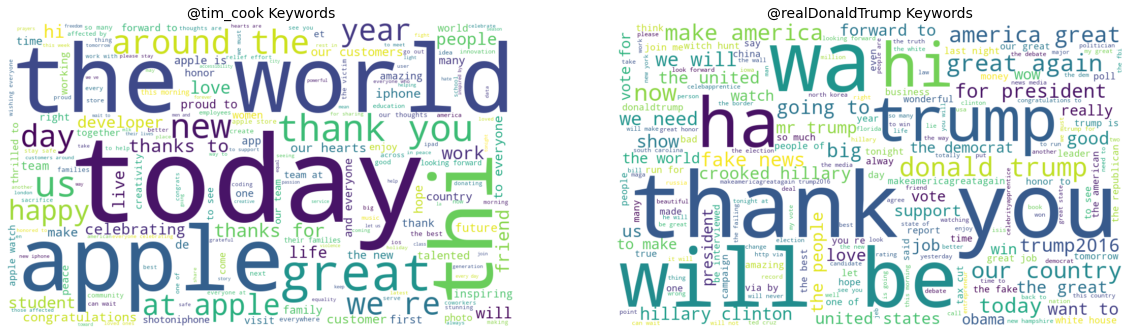

In [56]:
#Loading the tweets of only Donald Trump and Tim Cook for this EDA
folders=['tim_cook','realDonaldTrump']
fig=plt.figure(figsize=(20,20))
for i,ceo_handle in enumerate(folders):
    ax=fig.add_subplot(1,2,i+1)
    tweets=get_tweets_list(ceo_handle)
    tweets.reverse()
    wc=generate_wordcloud(tweets)
    plot_wordcloud(wc,f'@{ceo_handle} Keywords')

In [57]:
print('Example Tweets')
for i,ceo_handle in enumerate(folders):
    print(ceo_handle + ': ' )
    tweets=get_tweets_list(ceo_handle)

Example Tweets
tim_cook: 
realDonaldTrump: 


In [58]:
def calc_sentiment(tweets):
    pol = []
    sub = []
    time = []
    for tweet in tweets:
        ss = TextBlob(tweet['text']).sentiment
        date = tweet['date'].split(' ')[0]
        date=dt.datetime.strptime(date,'%Y-%m-%d')
        polarity_dic[date]=ss[0]
        subj_dic[date]=ss[1]
    return (polarity_dic,subj_dic)

/Users/garima/pydarn/venv_pydarn/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


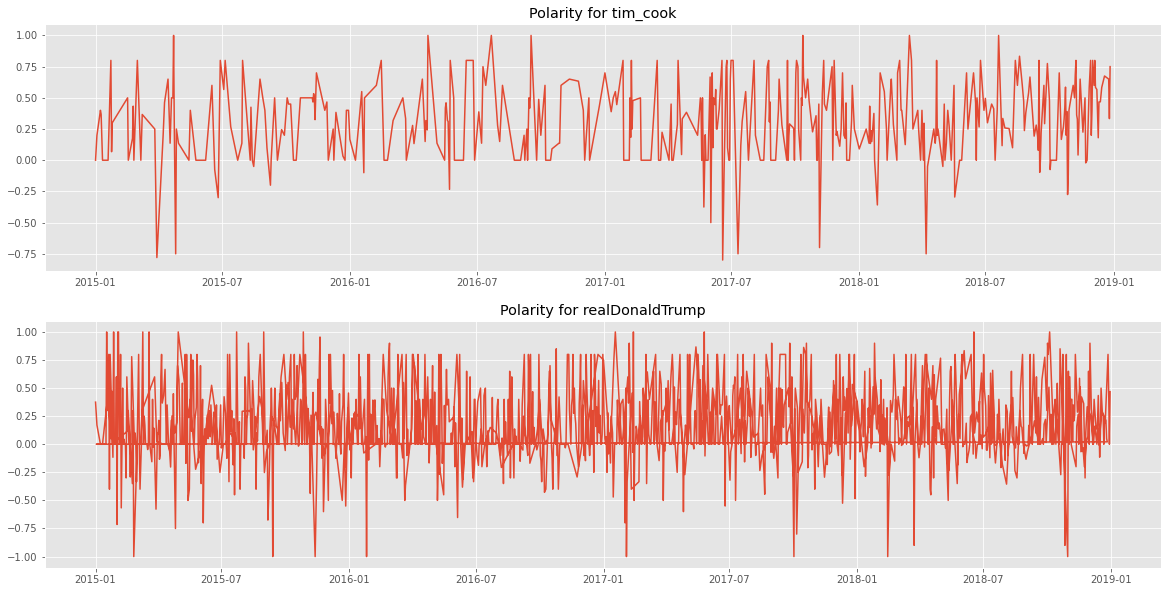

In [55]:
fig=plt.figure(figsize=(20,10))
polarity_dic=OrderedDict()
subj_dic=OrderedDict()
for i,ceo_handle in enumerate(folders):
    tweets=get_tweets_list(ceo_handle)
    tweets.reverse()
    polarity_dic,subj_dic=calc_sentiment(tweets)
    df=pd.DataFrame([polarity_dic]).T
    df.to_csv(ceo_handle+'_polarity.csv')
    df=pd.DataFrame([subj_dic]).T
    df.to_csv(ceo_handle+'_subjectivity.csv')
    
    ax=fig.add_subplot(2,1,i+1)
    dtimes=list(polarity_dic.keys())
    ax.plot(dtimes,list(polarity_dic.values()))

    ax.set_title('Polarity for '+ceo_handle)

The number of data points is much larger for realDonaldTrump than tim_cook and is more polarised than tim_cook's.

# Creating Interactive Apps using Bokeh

In [145]:
df_stocks_cut.to_csv('df_stocks_cut.csv')

In [50]:
from bokeh.themes import Theme
import yaml

In [51]:
%env BOKEH_ALLOW_WS_ORIGIN=localhost:8890

env: BOKEH_ALLOW_WS_ORIGIN=localhost:8890


In [56]:
df_select['as_of_date']=pd.to_datetime(df_select['as_of_date'])

In [143]:
output_notebook()
def bkapp(doc):
    TOOLS = 'crosshair,save,pan,box_zoom,reset,wheel_zoom'
    p = figure(title="Employees on Linkedin through Time", y_axis_type="log",x_axis_type='datetime', tools = TOOLS)
    
    df_comp=df_select[df_select['company_name']=='Apple']
   
    df_comp=df_comp.sort_values(by='as_of_date')
    source = ColumnDataSource(data={'x': df_comp['as_of_date'], 'y': df_comp['employees_on_platform']})
    source2 = ColumnDataSource(data={'x': df_comp['as_of_date'], 'y': df_comp['followers_count']})

    #p.line(df_comp['as_of_date'], df_comp['employees_on_platform'], legend=icomp, line_color="purple", line_width = 3)
    p.line(x='x',y='y',source=source,line_width=3,line_color="#f46d43",legend='Employees')
    p.line(x='x',y='y',source=source2,line_width=3,line_color="blue",line_alpha=0.3,legend='Followers')
    
    p.add_tools(HoverTool(show_arrow=False, line_policy='next', tooltips=\
                          [('Date', '@x{%F}'),('Employees', '@y')],\
                         formatters={'@x': 'datetime'}))
    p.plot_width =300

    def callback(attr, old, new):
        df_comp=df_select[df_select['company_name']==new]
        df_comp=df_comp.sort_values(by='as_of_date')
        y_val=df_comp['employees_on_platform']
        y_val2=df_comp['followers_count']
        df_new=pd.DataFrame({'x':df_comp['as_of_date'],'y':y_val})
        df_new2=pd.DataFrame({'x':df_comp['as_of_date'],'y':y_val2})
        
        source.data=ColumnDataSource.from_df(df_new)
        source2.data=ColumnDataSource.from_df(df_new2)
        
        sym_click=df_comp['Sym'].unique()[0]
        df_stock_new=df_stocks_cut[df_stocks_cut['Name']==sym_click]
        df_stock_new=df_stock_new.sort_values(by='date')
        yval=df_stock_new['high']
        df_new3=pd.DataFrame({'x':df_stock_new['date'],'y':yval})
        source3.data=ColumnDataSource.from_df(df_new3)


 
    #Figure 2
    #apple_sym='APL'
    p2 = figure(title="Stocks of the company through Time", y_axis_type="log",x_axis_type='datetime', tools = TOOLS)
    
    sym=df_select[df_select['company_name']=='Apple']['Sym'].unique()[0]
    df_stocks_comp=df_stocks_cut[df_stocks_cut['Name']==sym]
  
    df_stocks_comp=df_stocks_comp.sort_values(by='date')
    
    source3=ColumnDataSource(data={'x': df_stocks_comp['date'], 'y': df_stocks_comp['high']})
    
    p2.line(x='x',y='y',source=source3,line_width=3,line_color="#f46d43")
    p2.add_tools(HoverTool(show_arrow=False, line_policy='next', tooltips=\
                          [('Date', '@x{%F}'),('High', '@y')],\
                         formatters={'@x': 'datetime'}))
    
    p2.plot_width =300

    menu= Select(options=list(common_companies), value='Apple', title='Distribution')
    menu.on_change('value', callback) 
    
    ph=row(p,p2)
    doc.add_root(column(menu,ph))
    doc.theme = Theme(json=yaml.load("""
        attrs:
            Figure:
                background_fill_color: white
                outline_line_color: white
                toolbar_location: above
                height: 400
                width: 500
            Grid:
                grid_line_dash: [6, 4]
                grid_line_color: "#DDDDDD"
    """, Loader=yaml.FullLoader))
    
show(bkapp)

Loading BokehJS ...

By using this app at https://garimastocks.herokuapp.com/app, I observed that the increase 
in number of employees is not 
always directly related to trend in stocks. This needs further analysis. 
I am also interested in further looking if the sentiments of the CEOs
or the POTUS' has any influence on the stocks. As mentioned in the 
beginning of this notebook, I plan to use more datasets to build a high accuracy stocks predictor.

# Scraping and Analyzing the Employee Sentiments from Glassdoor


In [ ]:
'''
df_common=pd.read_csv('df_common.csv')
comp_names=df_common['company_name'].unique()

#scrape web pages for glassdoor pages of these companies 
def scrape_gs_urls():
    options=webdriver.ChromeOptions()
    options.add_argument('--headless')
    options.add_argument('--ignore-ssl-errors=yes')
    options.add_argument('--ignore-certificate-errors')
    browser=webdriver.Chrome(options=options)
    company_urls={}
    i=1
    for comp in comp_names:
        company_urls[comp]=np.nan
        print(comp)
        time.sleep(3)
        search_string="https://www.google.com/search?q="+\
                'reviews of '+comp+' on glassdoor'+'&start='+str(i)
        browser.get(search_string)
        html_source=browser.page_source
        soup=BeautifulSoup(html_source)
        divs=soup.find_all('div',attrs={'class':'r'})
        for div in divs:
            a_tags=div.find_all('a')
            tag_text=a_tags[0].text
            ipdb.set_trace()
            if ('Reviews' in tag_text) and ('glassdoor' in tag_text) : #check
                company_urls[comp]=a_tags[0]['href']
                break
            
    return company_urls

company_urls=scrape_gs_urls()
df_gs_urls=pd.DataFrame([company_urls]).T
df_gs_urls.to_csv('glassdoor_urls.csv')
'''

In [ ]:
'''
df_company_urls=pd.read_csv('glassdoor_urls.csv')
urls=df_company_urls['0'].values
comps=df_company_urls['Unnamed: 0'].values
company_urls=dict(zip(comps,urls))
'''

In [ ]:
#The main.py routine is primarily derived from the github repository here - 
# https://github.com/MatthewChatham/glassdoor-review-scraper
# But since the glassdoor page structure has changed, I made quite a few
# changes to this repository code.

'''
for comp,comp_url in company_urls.items():
    print(comp)
    path_name='gs_reviews_'+comp
    file_name=comp.replace(' ','_')+'_reviews.csv'
    if 'glassdoor' in comp_url : #eliminating any wrong links
        gs_link='"'+comp_url+'?sort.sortType=RD&sort.ascending=false'+'"'
        time.sleep(5)
        ! python main.py --headless --start_from_url --limit 9999 --min_date 2015-1-1 --url $gs_link -f $file_name
'''       

In [1]:
 def analyze_sent(string):
    try:
        string = string.lower()
        regs = [r'(\/\/www[^\s]+)',
        r'(pic.twitter.com\/[^\s]+)',
        r'(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)',
        r'(?i)\b((?:https?:\/\/[^\s]+))',
        r'https']
        prev = string
        for reg in regs:
            prev = re.sub(reg, " ", prev)
      
        sent=TextBlob(prev).sentiment[0]
        return sent
    except AttributeError:
        return np.nan 

In [7]:
#Importing the Glassdoor Reviews
comp_name_list=['Microsoft','Bank_of_America']
dic_sent={}   
for comp_name in comp_name_list:
    file_name=comp_name+'_reviews.csv'
    df_gs_review=pd.read_csv('glassdoor-review-scraper/'+file_name)
    df_gs_review=df_gs_review.sort_values(by='date')
    dtime_arr=df_gs_review['date']
    pros=df_gs_review['pros'].values
    cons=df_gs_review['cons'].values
    rec=df_gs_review['recommends'].values
    pos_outlook=df_gs_review['positive_outlook'].values
    approves_ceo=df_gs_review['approves_of_CEO'].values
     
    tot_sent_polar_arr={}
   
    for i,ele in enumerate(pros):
        pros_polar=analyze_sent(pros[i])
        cons_polar=analyze_sent(cons[i])
        rec_polar=analyze_sent(rec[i])
        pos_olk=analyze_sent(pos_outlook[i])
        app_ceo=analyze_sent(approves_ceo[i])
        
        #print('Pros Polarity : ', ele , ' = ', pros_polar)
        #print('Cons Polarity : ',cons[i], ' = ', cons_polar)
        #print('Recommends Polarity : ',rec[i], ' = ', rec_polar)
        #print('Positive Outlook Polarity : ', pos_outlook[i], ' = ', pos_olk)
        #print('Approves CEO Polarity : ', approves_ceo[i], ' = ', app_ceo)
        
        tot_sent_polar=pros_polar+cons_polar+rec_polar+pos_olk+app_ceo
        
        #print('Total Polarity : ', tot_sent_polar)
        
        tot_sent_polar_arr[dtime_arr[i]]=tot_sent_polar
        
    dic_sent[comp_name]=tot_sent_polar_arr
       

In [8]:
dic_sent.keys()

dict_keys(['Microsoft', 'Bank_of_America'])

In [60]:
import matplotlib.dates as mdates

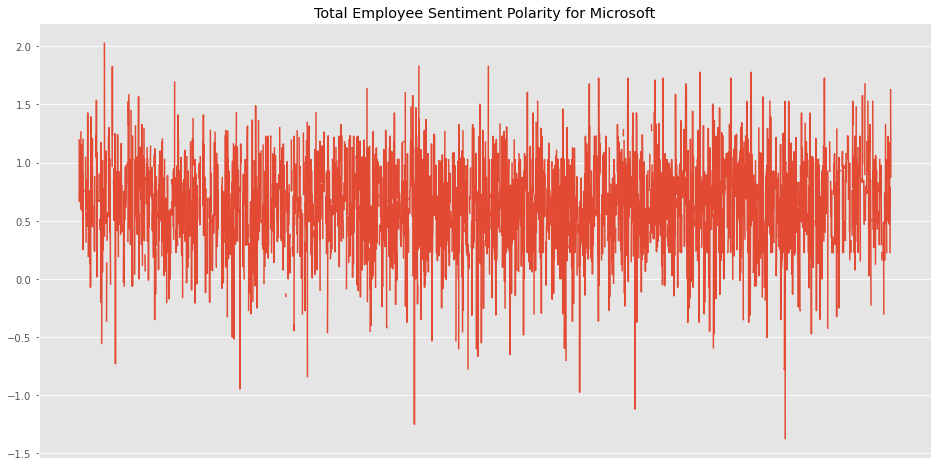

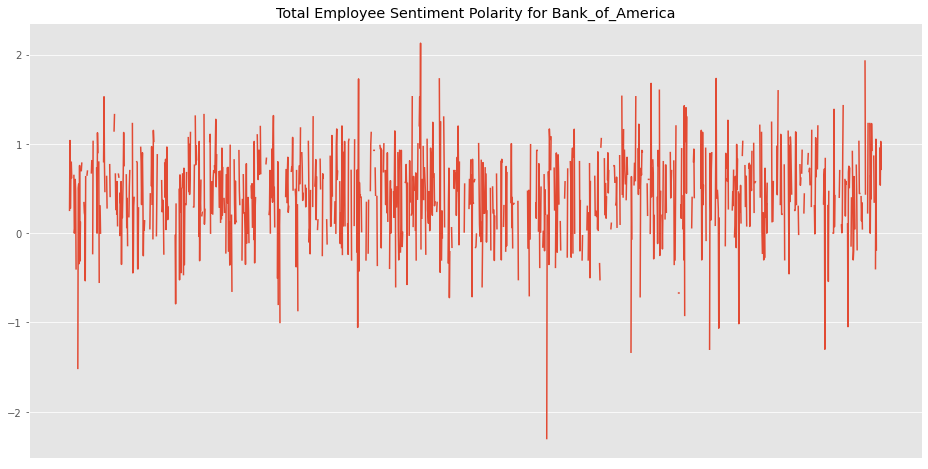

In [62]:
for comp_name in comp_name_list:
    fig=plt.figure(figsize=(16,8))
    ax=fig.add_subplot(111)
    ax.plot(list(dic_sent[comp_name].keys()),list(dic_sent[comp_name].values()))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    myFmt = mdates.DateFormatter("%Y")
    ax.xaxis.set_major_formatter(myFmt)
    ax.set_title('Total Employee Sentiment Polarity for '+ comp_name)

In [ ]:
import pytz

Text(0.5, 1.0, 'Political Sentiment : Donal Trump Tweets')

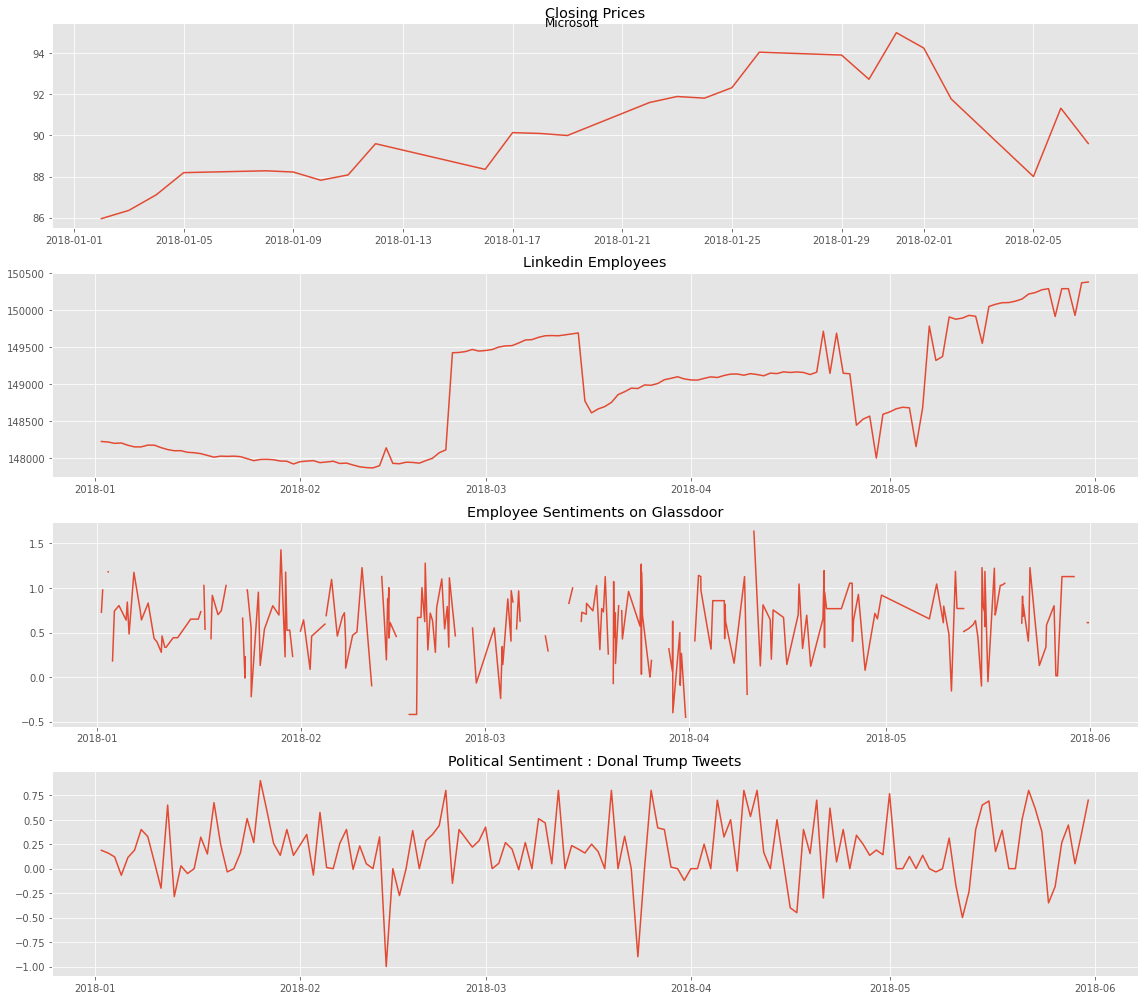

In [103]:
#Looking at only a few data points
df_sel=df_stocks_cut[df_stocks_cut['Name']=='MSFT']
df_sel=df_sel.sort_values(by='date')
fig=plt.figure(figsize=(16,14))
ax=fig.add_subplot(411)
dtime_sel=df_sel[(df_sel['date']>dt.datetime(2018,1,1)) & (df_sel['date']<dt.datetime(2018,6,1))]
ax.plot(dtime_sel['date'],dtime_sel['close'])
fig.suptitle('Microsoft')
ax.set_title('Closing Prices')

df_select=df_select[df_select['company_name']=='Microsoft']
#fig=plt.figure(figsize=(16,8))
ax=fig.add_subplot(412)
dtime_select=df_select[(df_select['as_of_date']>dt.datetime(2018,1,1)) & (df_select['as_of_date']<dt.datetime(2018,6,1))]
ax.plot(dtime_select['as_of_date'],dtime_select['employees_on_platform'])
ax.set_title('Linkedin Employees')

comp_name='Microsoft'
dtimes=pd.to_datetime(np.array(list(dic_sent[comp_name].keys())))
emp_sents=np.array(list(dic_sent[comp_name].values()))
df_microsoft=pd.DataFrame(list(zip(dtimes,emp_sents)), columns=['date','employee_sent'])
df_microsoft=df_microsoft.sort_values(by='date')
low_lim=dt.datetime(2018,1,1).replace(tzinfo=pytz.UTC)
high_lim=dt.datetime(2018,6,1).replace(tzinfo=pytz.UTC)
dtime_select=df_microsoft[(df_microsoft['date']>low_lim) & (df_microsoft['date']<high_lim)]
ax=fig.add_subplot(413)
ax.plot(dtime_select['date'],dtime_select['employee_sent'])
ax.set_title('Employee Sentiments on Glassdoor')

tweet_handle='realDonaldTrump'
df_tweet=pd.read_csv(tweet_handle+'_polarity.csv')
df_tweet['Unnamed:0']=pd.to_datetime(df_tweet['Unnamed: 0'])
df_tweet=df_tweet.sort_values(by='Unnamed:0')
dtime_select=df_tweet[(df_tweet['Unnamed:0']>dt.datetime(2018,1,1)) & (df_tweet['Unnamed:0']<dt.datetime(2018,6,1))]
#fig=plt.figure(figsize=(16,8))
ax=fig.add_subplot(414)
ax.plot(dtime_select['Unnamed:0'],dtime_select['0'])
plt.tight_layout()
ax.set_title('Political Sentiment : Donal Trump Tweets')